In [ ]:
import requests 
from bs4 import BeautifulSoup as bsoup

# Data Scraping of Article links in Blog

In [ ]:
def get_articles_dataquest(url1, prev_count=0):
    result = requests.get(url1)
    page = result.content
    soup = bsoup(page, 'html.parser')
    
    # get all links of article
    articles = soup.find_all("article", "post")
    articles_links = {}
    for article in articles:
        heading = article.find("h2", "post-title")
        title = heading.string.strip()
        articles_links[title] = "https://www.dataquest.io" + heading.find("a").attrs['href']
    
    # collect data from each article
    articles_data = {}
    for (i, (title, link)) in enumerate(articles_links.items()):
        page = bsoup(requests.get(link).content, 'html.parser')
        article = {}
        article['title'] = page.find("h1", class_="post-title").string.strip()
        article['link'] = link 
        section = page.find("section", class_="post-content")
        paragraphs = section.find_all("p")
        paras = ' '
        for para in paragraphs:
            paras = paras + ' ' + para.getText()
        article['content'] = paras

        if section.find("code"):
            article['code'] = 1
        else:
            article['code'] = 0

        articles_data[i + prev_count] = article
        
    return articles_data

In [ ]:
# scraping data from dataquest blog (TODO :generalize pages)
data1 = get_articles_dataquest("https://www.dataquest.io/blog")
data2 = get_articles_dataquest("https://www.dataquest.io/blog/page2",\
                               list(data1.keys())[-1]+1)
data3 =  get_articles_dataquest("https://www.dataquest.io/blog/page3",\
                                list(data2.keys())[-1]+1)

In [ ]:
data = data1.copy()
data.update(data2)
data.update(data3)
with open('dataquest_data.json','w') as outfile:
    json.dump(data,outfile)
    

# Document clustering

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import json
from nltk.stem.snowball import SnowballStemmer

# Load data
with open('dataquest_data.json') as data_file:    
    data = json.load(data_file)


34

### Pre-Analysis

In [3]:
# Tokenizer and Stemmer for reducing similar words
## Direct source : http://brandonrose.org/clustering
stemmer = SnowballStemmer("english")

# here I define a tokenizer and stemmer which returns 
# the set of stems in the text that it is passed

def tokenize_and_stem(text, stem=1):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    if (stem == 1):
        stems = [stemmer.stem(t) for t in filtered_tokens]
        return stems
    else:
        return filtered_tokens

In [7]:
# create a lits of vocab of stems and token from all the content
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in [article["content"] for key, article in data.items()]:
    allwords_stemmed = tokenize_and_stem(i, 1) #for each article, tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_and_stem(i, 0) 
    totalvocab_tokenized.extend(allwords_tokenized)

# Creating a data frame with stemmed vocab as index and tokens as columns, 
# so that given a stem we can look up a token
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 50401 items in vocab_frame


## Feature Extraction : Bag of Words and frequency inverse document frequency weighting
### feature matrix is obtained in two steps:
1. A matrix of frequency of words in the document is made. Only words which appear in atleast min_idf fraction of documents and less than max_df fraction of documents are considered.
2. Words in each document column are inverse weighted based on how frequently they appear in the data corpus. Words which appear frequently in a document but not frequently in the corpus get higher weighting.

### Catch: Had to play around with the parameters to get a sensible list of words used in feature vectorization


In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define parameters for Term frequency inverse document frequency matrix
tfidf_vectorizer = TfidfVectorizer(max_df= 0.40, \
                             max_features = 1000, min_df = 0.1,\
                             stop_words = 'english',\
                             tokenizer=tokenize_and_stem,\
                             use_idf = True, ngram_range=(1,5))

# tf_idf matrix
%time tfidf_matrix = tfidf_vectorizer.fit_transform([article['content'] for key, article in data.items()])

## 

CPU times: user 2.07 s, sys: 0 ns, total: 2.07 s
Wall time: 2.07 s


In [ ]:
# list of features used for the features matrix
terms = tfidf_vectorizer.get_feature_names()



In [252]:
tfidf_matrix.shape

(34, 878)

In [263]:
## PCA for analyzing variability in data
from scipy.sparse.linalg import svds

U, s, VT = svds(tfidf_matrix[:,:20].T, k=2)
pca = tfidf_matrix[:,:20].dot(U)

#plt.plot(mlab_pca.Y[0:20,0],mlab_pca.Y[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
#plt.plot(mlab_pca.Y[20:40,0], mlab_pca.Y[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

#plt.xlabel('x_values')
#plt.ylabel('y_values')
#plt.xlim([-4,4])
#plt.ylim([-4,4])
#plt.legend()
#plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

#plt.show()

In [266]:
pca.shape

(34, 2)

In [223]:
## Measuring similarity of documents
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## K-Means Clustering
It starts out with picking a specified number of clusters. At first centroids of the clusters are initialized randomly.

Repeat untill convergence
1. Each data point is assigned to a cluster based on it's closenness in euclidean distance
2. For each cluster new centroid is computed by computing mean of data points.


In [224]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib
num_clusters = 3
km = KMeans(n_clusters = num_clusters)
%time km.fit(features)
clusters = km.labels_.tolist()

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 50.4 ms


In [225]:
#pickle the model
joblib.dump(km, 'article_cluster.pkl')
km = joblib.load('article_cluster.pkl')
clusters = km.labels_.tolist()

In [226]:
# Creating a dataframe for easy access grouped by cliuster from tiles, code, link and content
grouped_data = {'title': [article['title'] for article in data.values()],\
               'link': [article['link'] for article in data.values()],\
               'code': [article['code'] for article in data.values()],\
               'content': [article['content'] for article in data.values()],\
                'cluster': clusters }
frame = pd.DataFrame(grouped_data, index = [clusters], columns = ['title', 'link', 'code','content', 'cluster'])    

In [228]:
# To get an idea of main topic of the cluster, 
# we get the words closest to the cluster centroid
## Direct source : http://brandonrose.org/clustering
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :15]: 
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8','ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()



Cluster 0 words: b'future', b'Environment', b'iterate', b'looking', b'indicates', b'extremely', b'changed', b'defines', b'explanations', b'didn\xe2\x80\x99t', b'can\xe2\x80\x99t', b'amazing', b'Credit', b'average', b'hand',

Cluster 0 titles: PySpark: How to install and Integrate with the Jupyter Notebook, Python Counter Class and Probability Mass Functions, Python data visualization: Comparing 7 tools, Docker: Data Science Environment with Jupyter, DigitalOcean & Docker for Data Science, Python API tutorial - An Introduction to using APIs, Building a data science portfolio: Making a data science blog, Matplotlib tutorial: Plotting tweets mentioning Trump, Clinton & Sanders, Data Scientist Interview: Benjamin Root, Apache Spark: An Introduction,

Cluster 1 words: b'blog', b'looking', b'got', b'index', b'bit', b'little', b'collaboration', b'accurate', b'lengths', b'Credit', b'input', b'code', b'contain', b'learn', b'dominant',

Cluster 1 titles: Cleaning CSV Data Using the Command Line

In [231]:
## Plotting Clusters , using matplotlib and D3
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# Distance matrix is precomputed from the feature matrix (tfidf_matrix)
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()


#specify cluster colors
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#cluster names chosen based on words closest to cluster centroids
cluster_names = {0: 'Environment', 
                 1: 'Code', 
                 2: 'Interview'}

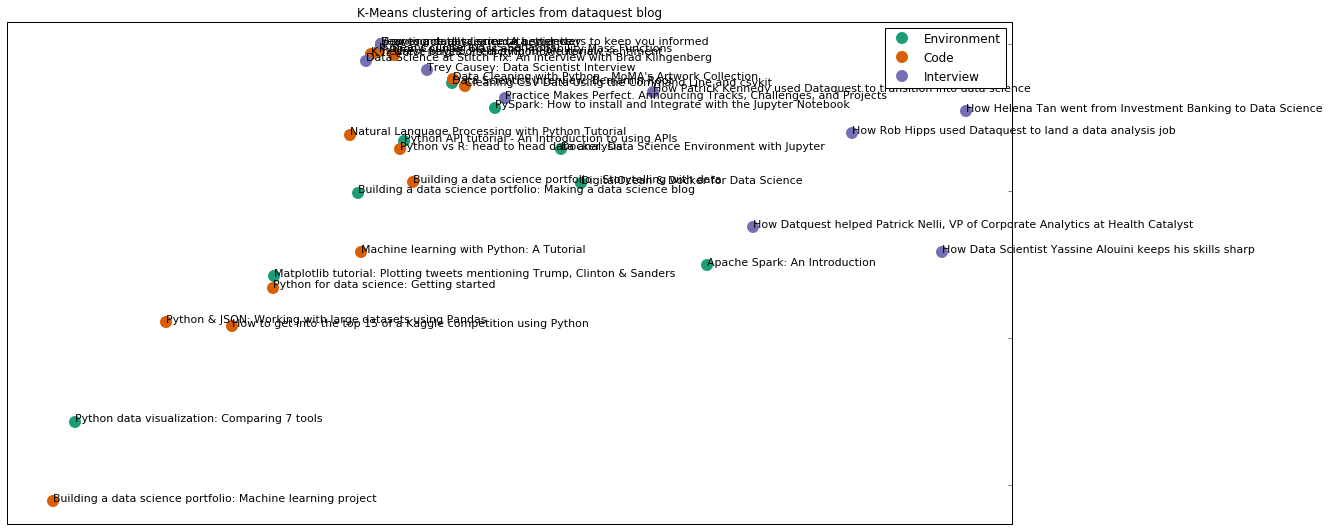

In [272]:
#some ipython magic to show the matplotlib plots inline
# code source : http://brandonrose.org/clustering
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=[article['title'] for article in data.values()])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(18, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
ax.set_title('K-Means clustering of articles from dataquest blog')
#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=11)  

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('article_clustering.png', dpi=300)

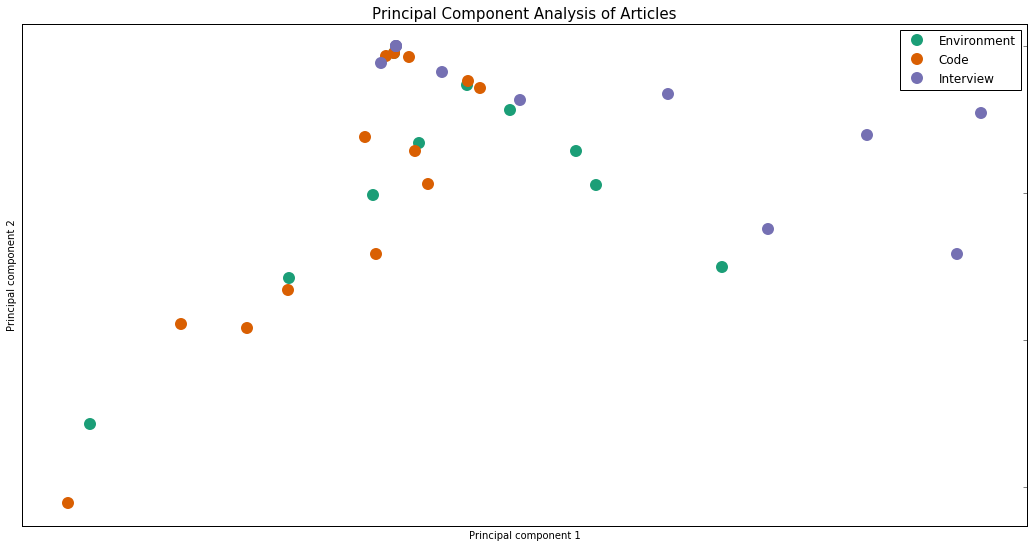

In [276]:
#some ipython magic to show the matplotlib plots inline
# code source : http://brandonrose.org/clustering
xs = pca[:,0]
ys = pca[:,1]
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=[article['title'] for article in data.values()])) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(18, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
ax.set_xlabel("Principal component 1")  
ax.set_ylabel("Principal component 2")
ax.set_title("Principal Component Analysis of Articles", size=15)
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('article_pca.png', dpi=300)